In [120]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os, random

from modules.painting import painting
from modules.database import database as db

from keras.models import Sequential, Model
from keras.layers.core import (Dropout, Flatten, Dense, Activation)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import (RandomFlip, RandomRotation, Input, BatchNormalization, 
                          RandomTranslation, RandomZoom)
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19, preprocess_input

#### Control Variables

In [2]:
# setting path variables for Working Directory and folder to save and load
#   models from.
wd = os.getcwd()
WD_PATH =  os.path.abspath(wd)
PATH_TRAINING = os.path.join(WD_PATH, "model_training")

# # initializing the database object
gallery = db()

# ### How many pictures should be used per artist
TOTAL_PAINTINGS = 3971
SIZE_TRAINING = 190
SIZE_TESTING = 38
SIZE_UNUSED = 3971 - ((SIZE_TESTING + SIZE_TRAINING) * 10 )
PIXEL_SIZE = 128

#### Loading data from DB

In [3]:
## creating arrays to hold the pictures taken from the DB
testing_images = np.zeros((10*SIZE_TESTING,PIXEL_SIZE,PIXEL_SIZE,3))
index_testing = 0
skip_count_testing = 0
training_images = np.zeros((10*SIZE_TRAINING,PIXEL_SIZE,PIXEL_SIZE,3))
index_training = 0
skip_count_training = 0
# creating the arrays to hold labels. In this case they are the artist ids.
# testing_labels = np.zeros((10*SIZE_TESTING,1),dtype=int)
# training_labels = np.zeros((10*SIZE_TRAINING,1),dtype=int)
testing_labels = np.array([0]*SIZE_TESTING*10,dtype=int)
training_labels = np.array([0]*SIZE_TRAINING*10,dtype=int)
unused_paintings = np.array([0]*SIZE_UNUSED,dtype=int)


# filling the arrays with picture arrays. They will be resized according
# to the pixel_size value
unused_index = 0
for i in range(1,11):
    ids = gallery.get_paintingids_from_artist(i)
    # random.seed(1983)
    random.shuffle(ids)
    ids_training = ids[ : SIZE_TRAINING]
    ids_testing = ids[SIZE_TRAINING : SIZE_TRAINING + SIZE_TESTING]
    ids_unused = ids[SIZE_TRAINING + SIZE_TESTING : ]
    for l, f in zip(range(unused_index,unused_index+len(ids_unused))
                    , ids_unused):
        unused_paintings[l] = f[0]
    unused_index += len(ids_unused)
    for j in ids_testing:
        temp_p = painting("local DB", id=j[0])
        temp_p_res = cv.resize(temp_p.ndarray, dsize=(PIXEL_SIZE,PIXEL_SIZE)
                               ,interpolation=cv.INTER_CUBIC)
        if temp_p_res.shape == (PIXEL_SIZE,PIXEL_SIZE,3):
            testing_images[index_testing] = temp_p_res
            testing_labels[index_testing] = temp_p.artist_id-1
            # testing_labels[index_testing] = [temp_p.artist_id-1,]
            index_testing += 1
        else:
            skip_count_testing += 1
    # print("Testing images status")
    # print(index_testing)
    # print(skip_count_testing)
    for k in ids_training:
        temp_p = painting("local DB", id=k[0])
        temp_p_res = cv.resize(temp_p.ndarray, dsize=(PIXEL_SIZE,PIXEL_SIZE)
                               ,interpolation=cv.INTER_CUBIC)
        if temp_p_res.shape == (PIXEL_SIZE,PIXEL_SIZE,3):
            training_images[index_training] = temp_p_res
            training_labels[index_training] = temp_p.artist_id-1
            # training_labels[index_training] = [temp_p.artist_id-1,]
            index_training += 1
        else:
            skip_count_training += 1
    # print("Training images status")
    # print(index_training)
    # print(skip_count_training)

# ## dropping the last few array positions of testing images, which where 
# ## not filled.
testing_images = testing_images[:index_testing,:,:,:]
testing_labels = testing_labels[:index_testing]

# # the pixels on an image are rescaled from 0-255 to 0-1 
training_images, testing_images = training_images/255, testing_images/255 

# defining labels in a list
class_names = [i[1] for i in gallery.get_all_artists()]

#### Checking data shapes

In [4]:
print(training_images.shape)
print(testing_images.shape)
print(training_labels.shape)
print(testing_labels.shape)
print(type(training_labels[185:200]))

(1900, 128, 128, 3)
(358, 128, 128, 3)
(1900,)
(358,)
<class 'numpy.ndarray'>


In [171]:
from tensorflow import unique_with_counts
y, idx, count = unique_with_counts(training_labels)


In [28]:
print(training_labels[500:510])

[2 2 2 2 2 2 2 2 2 2]


In [ ]:
# print(np.unique(training_labels))
# print(type(training_labels[21]))
# print(training_labels[21].shape)
# print(training_labels[500])
# print(training_labels[:,0].shape)
# print(type(training_labels[:,0]))

In [124]:
base_model = VGG19(include_top = False,
                   classes = 10, 
                   input_shape = (PIXEL_SIZE, PIXEL_SIZE, 3))

base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [125]:
# Layer for the model. 
## data augmentation counteracting the small number of paintings
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomFlip('vertical'),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
])
prediction = Sequential([
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512),
    Dense(10, activation = 'softmax'),
])

In [126]:
# Creating the model from basemodel and the other layers.
inputs = Input(shape=(PIXEL_SIZE, PIXEL_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
outputs = prediction(x)
model = Model(inputs, outputs)

In [127]:
# compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 sequential_5 (Sequential)   (None, 10)                4464

In [250]:
## training the model
epochs = 100
batch_size = 8

early_stopping = EarlyStopping(patience = 20, 
                               verbose = 2, 
                               restore_best_weights = True)
    
history = model.fit(training_images,
                    training_labels,
                    validation_data = (testing_images, testing_labels),
                    # class_weight = class_weights,
                    epochs = epochs,
                    batch_size = batch_size,
                    callbacks = early_stopping)

Epoch 1/12
238/238 [==============================] - 94s 395ms/step - loss: 2.0423 - accuracy: 0.2795 - val_loss: 46.3121 - val_accuracy: 0.1061
Epoch 2/12
238/238 [==============================] - 95s 400ms/step - loss: 2.0388 - accuracy: 0.2858 - val_loss: 35.8180 - val_accuracy: 0.1061
Epoch 3/12
  1/238 [..............................] - ETA: 1:22 - loss: 1.8332 - accuracy: 0.3750

In [ ]:
model.save(os.path.join(PATH_TRAINING,"image_classifier_BvD_withVGG19basemodel.model"))

In [ ]:
model = models.load_model(os.path.join(PATH_TRAINING,"image_classifier_BvD_withVGG19basemodel.model"))

#### check one prediction

3021
(1, 128, 128, 3)
1/1 [==============================] - 0s 66ms/step
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
7
Prediction is Rembrandt


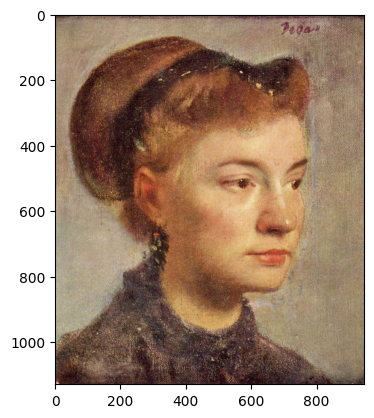

In [248]:
test_painting = painting("local DB",random.choice(unused_paintings))
print(test_painting.id)
test_ndarray = cv.resize(test_painting.ndarray, dsize=(PIXEL_SIZE,PIXEL_SIZE)
                               ,interpolation=cv.INTER_CUBIC)
test_ndarray = test_ndarray/255
temp_array = np.zeros((1,PIXEL_SIZE,PIXEL_SIZE,3))
print(temp_array.shape)
temp_array[0] = test_ndarray
prediction = model.predict(temp_array)
np.set_printoptions(suppress=True)
print(np.round(prediction, 4))
print(np.argmax(prediction))
index = np.argmax(prediction)
print(f"Prediction is {class_names[index]}")
imgplot = plt.imshow(test_painting.ndarray)
plt.show()